# Threshold Histograms (across calibration samples)

This notebook reads the th_log.txt (if was created) and presents for every 
(layer,head,row) a histogram of per-calibration-example thresholds. Where each
per-example threshold was obtained by the (1-k/seqlen)th percentile, and recorded 
to a separate line in th_log.txt

The prerequisites for running this notebook:
1. *th_log.txt*  - obtained during the calibration using a single k for every layer,head,row.
   This is (rather than sampling multiple thresholds for multiple Ks as required for an MKC calibration)
   each line looks like this:

   L0_H0 512 1149 0.0006890296936035156

2. *th.txt* - final calibrated thresholds
   each line looks like this:
   
   L31_H31:1219 0.0002257227897644043 4 64.0

Current results are on aime03

In [3]:

from matplotlib import pyplot as plt
from typing import Tuple
import pandas as pd
import itertools
from tqdm.notebook import tqdm
import os


LAYERS=[0,1,10,31]  # "ALL" string or a list of layer ids [0,1,10,31] to take into account for the barplot
HEADS=[0,4,16,20]  # "ALL" or a list of head ids [0,1,10,31] to take into account for the barplot
ROWS=[600,800,1000]

PLOT_TITLE="LLaMA2-7b Arc_challenge post-softmax calibration with single k - MEAN + 0.1STD aggregation"
RUN_NAME='2024-12-03_15-28-20_570144' # k=128

# PLOT_TITLE="LLaMA2-7b Arc_challenge post-softmax calibration with single k - MEAN aggregation"
# RUN_NAME='2024-04-05_17-40-19_628488'

# PLOT_TITLE="LLaMA2-7b Arc_challenge pre-softmax calibration with single k - MEAN aggregation"
# RUN_NAME='2024-04-05_17-40-22_693708'


model_layers = {'LLaMA2-7b':32, 'LLaMA2-70b':80}
model_heads = {'LLaMA2-7b':32, 'LLaMA2-70b':64}
model_num_attn_layers = None
model_num_attn_heads = None
for model_name in model_layers.keys():
    if model_name.lower() in PLOT_TITLE.lower():
        model_num_attn_layers = model_layers[model_name]
        model_num_attn_heads = model_heads[model_name]
        break
if model_num_attn_layers is None or model_num_attn_heads is None:
    print(f"Error: the provided -run_name \"{PLOT_TITLE}\" must contain one of the supported models:")
    print(' ' + '\n '.join(model_layers.keys()))
    exit(-1)

layers = list(range(model_num_attn_layers) if LAYERS == "ALL" else filter(lambda l: 0<=l<model_num_attn_layers, LAYERS))
heads = list(range(model_num_attn_heads) if HEADS == "ALL" else filter(lambda h: 0<=h<model_num_attn_heads, HEADS))
rows = ROWS

In [4]:
# Read the th_log.txt file (only the interesting layers,heads,rows)
# Each line looks like:
# L0_H0 512 1149 0.0006890296936035156
dict_per_row_lst = []
configs_of_interest = set(itertools.product(layers, heads, rows))
with open(f"../products/{RUN_NAME}/th_log.txt", "r") as f:
    print("Reading lines to memory")
    for line in tqdm(f.readlines(), desc="parsing th_log"):
        l_h, k, r, threshold = line.split(" ")
        l, h = l_h.split("_")
        l = int(l[1:]) # drop the L of L0
        h = int(h[1:]) # drop the H of H0
        k = int(k)
        r = int(r)
        threshold = float(threshold)
        if (l,h,r) in configs_of_interest:
            dict_per_row_lst.append({'layer':l, 'head':h, 'row':r, 'k':k, 'threshold':threshold})
df = pd.DataFrame(dict_per_row_lst)
df

Reading lines to memory


parsing th_log:   0%|          | 0/1618144256 [00:00<?, ?it/s]

,layer,head,row,k,threshold
0,0,0,800,512,0.000664
1,0,0,1000,512,0.000702
2,0,4,800,512,0.000535
3,0,4,1000,512,0.000556
4,0,16,800,512,0.000877
...,...,...,...,...,...
70387,10,20,600,128,0.000093
70388,31,0,600,128,0.000132
70389,31,4,600,128,0.000038
70390,31,16,600,128,0.000293


In [5]:
# Read the calibrated threshold that was eventually aggregated for each layer,head,row
def get_calibrated_th_effk(th_txt_path:str, layer:int, head:int, seq_len:int) -> Tuple[float, float]:
    """
    Read the calibrated threshold and the corresponding effective k (effective 
    on the calibration set) for the specified (layer, head, seqlen)
    """
    with open(th_txt_path) as f:
        for line in f.readlines():
            # one line looks like:
            # L31_H31:1219 0.0002257227897644043 4 64.0
            header, th, num_samples, effk = line.split(" ")
            if header == f"L{layer}_H{head}:{seq_len}":
                return float(th), float(effk)
    return None, None

calib_th_lst = []
for l,h,r in tqdm(list(itertools.product(layers, heads, rows)), desc="reading calibrated thresholds"):
    calib_th, _ = get_calibrated_th_effk(f"../products/{RUN_NAME}/th.txt", l, h, r)
    calib_th_lst.append({'layer':l, 'head':h, 'row':r, 'calibrated_threshold':calib_th})
df_calib_th = pd.DataFrame(calib_th_lst)
df_calib_th

reading calibrated thresholds:   0%|          | 0/48 [00:00<?, ?it/s]

,layer,head,row,calibrated_threshold
0,0,0,600,0.000569
1,0,0,800,0.000624
2,0,0,1000,0.000621
3,0,4,600,0.000448
4,0,4,800,0.000575
5,0,4,1000,0.000571
6,0,16,600,0.000815
7,0,16,800,0.000817
8,0,16,1000,0.000771
9,0,20,600,0.000822


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


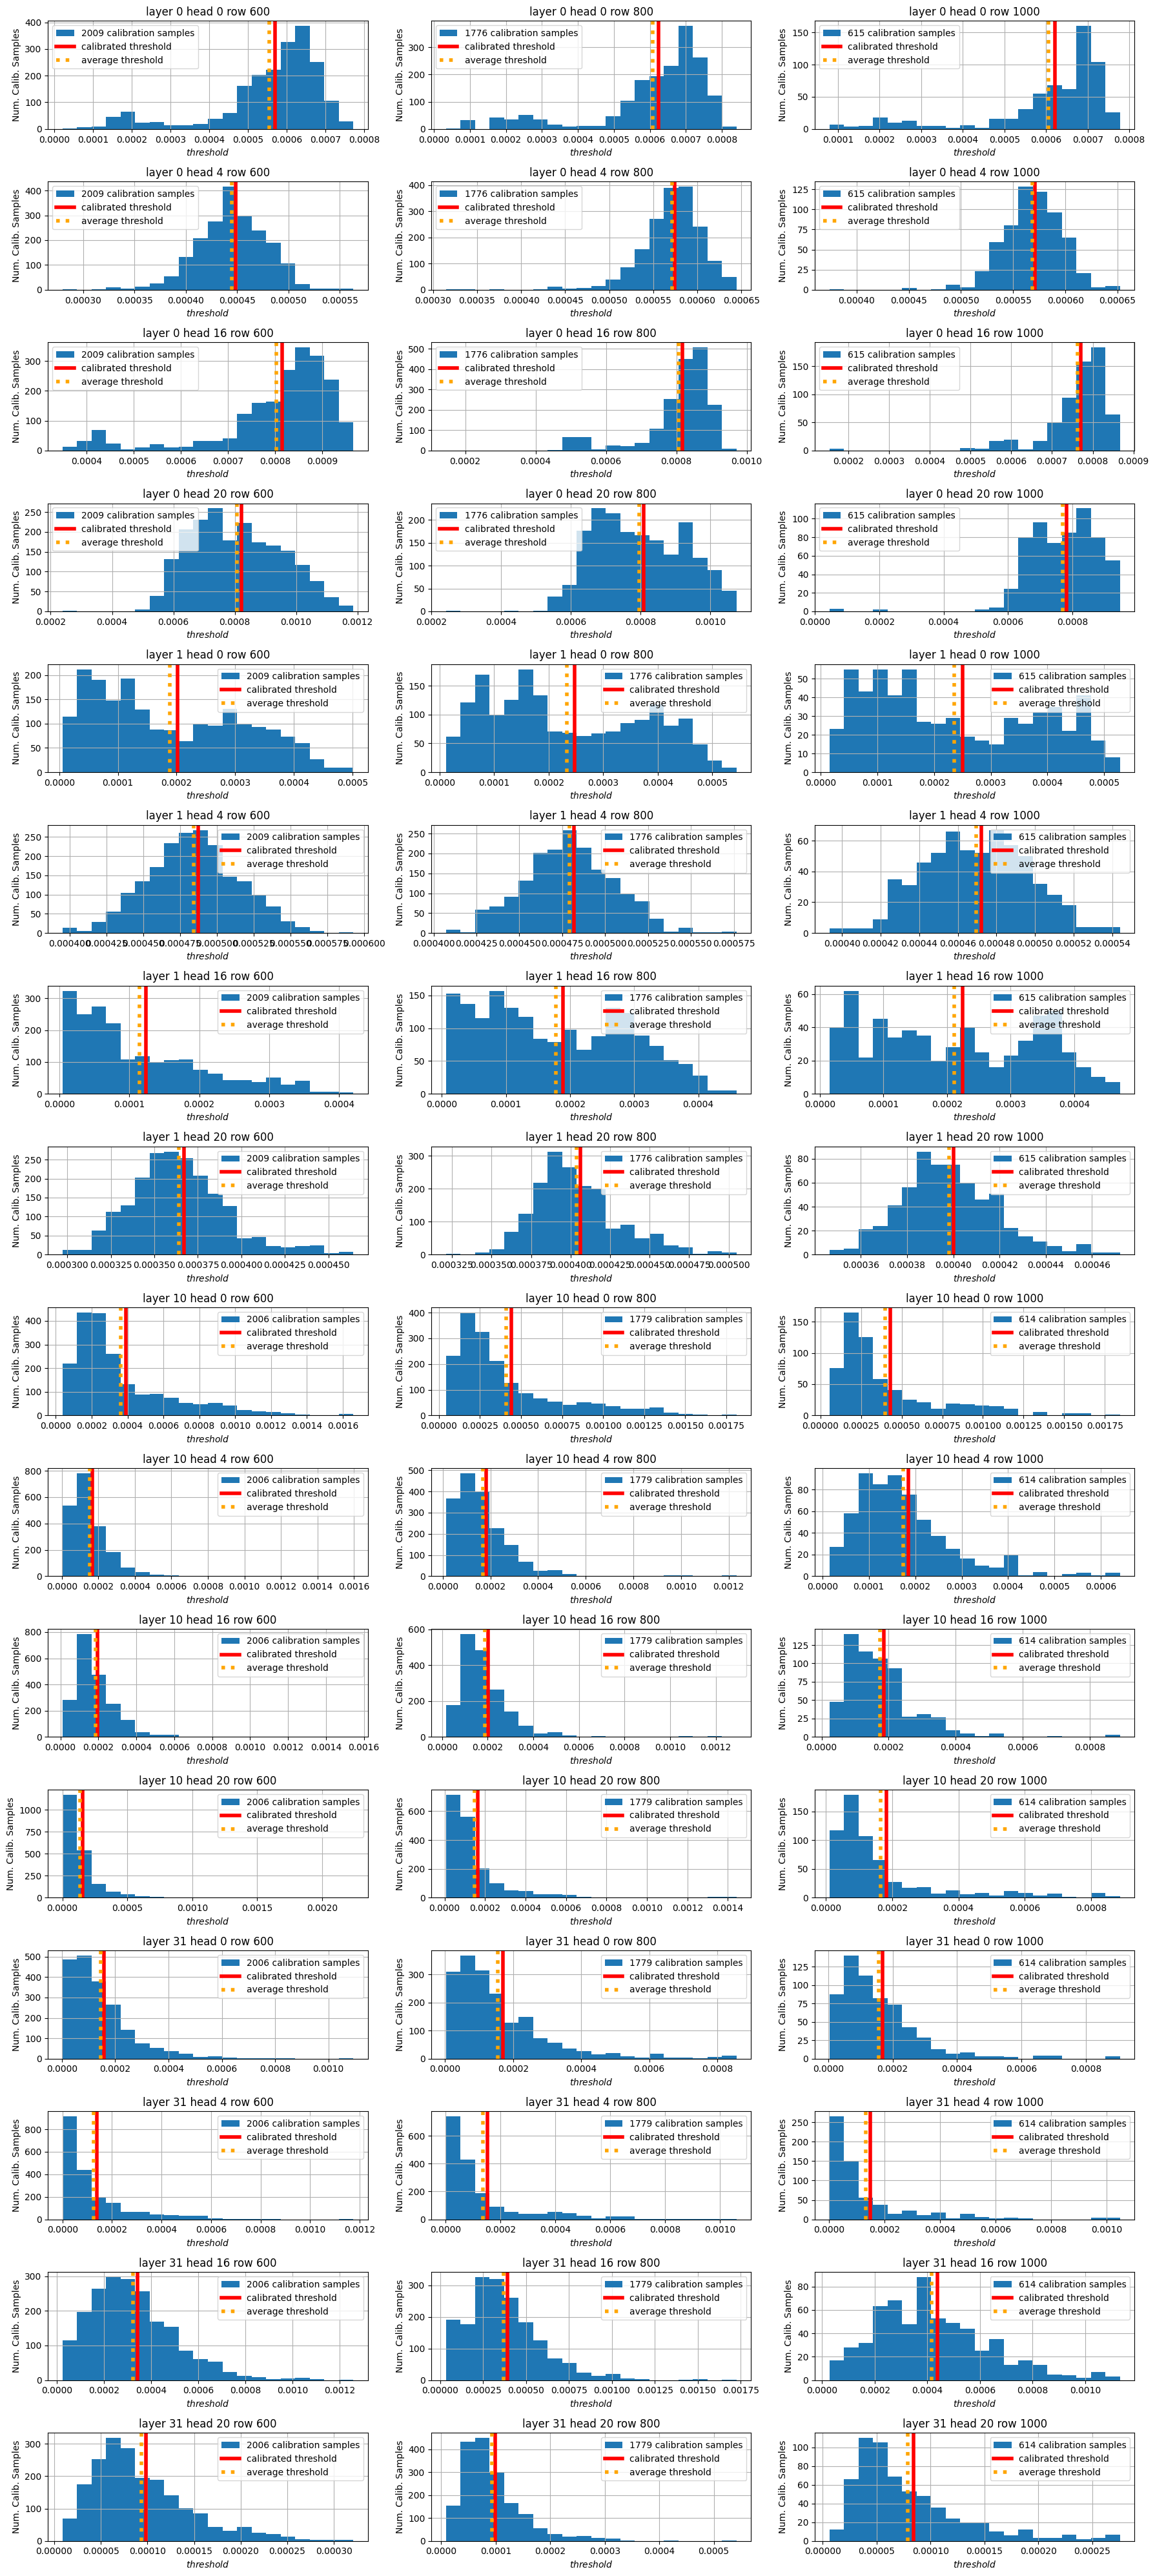

In [6]:
fig, ax = plt.subplots(len(layers)*len(heads),len(rows), figsize=(6*len(rows),2.5*len(layers)*len(heads)))
for fig_row, (layer, head) in enumerate(itertools.product(layers, heads)):
    for fig_col, row in enumerate(rows):
        # print(f"ax[{fig_row},{fig_col}] = layer {layer} head {head} row {row}")
        calibrated_threshold = df_calib_th[(df_calib_th['layer'] == layer) & (df_calib_th['head'] == head) & (df_calib_th['row'] == row)].calibrated_threshold.item()
        df_lhr = df[(df['layer'] == layer) & (df['head'] == head) & (df['row'] == row)]
        df_lhr.threshold.hist(bins=20, ax=ax[fig_row, fig_col], label=f'{len(df_lhr)} calibration samples')
        ax[fig_row, fig_col].axvline(x=calibrated_threshold, linewidth=4, color='r', label='calibrated threshold')
        ax[fig_row, fig_col].axvline(x=df_lhr.threshold.mean(), linewidth=4, color='orange', ls=':', label='average threshold')
        ax[fig_row, fig_col].legend()
        ax[fig_row, fig_col].set_xlabel('$threshold$')
        ax[fig_row, fig_col].set_ylabel('Num. Calib. Samples')
        ax[fig_row, fig_col].set_title(f'layer {layer} head {head} row {row}')
        
fig.tight_layout()
img_file_name = PLOT_TITLE.replace(" ","-")
img_dir_name = f'../figures/th_histograms/l-{LAYERS if LAYERS=="ALL" else "-".join(map(str, layers))}_heads-{HEADS if HEADS=="ALL" else "-".join(map(str, heads))}_rows-{ROWS if ROWS=="ALL" else "-".join(map(str, rows))}'
os.makedirs(img_dir_name, exist_ok=True)
plt.savefig(f'{img_dir_name}/{img_file_name}.png')
plt.savefig(f'{img_dir_name}/{img_file_name}.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


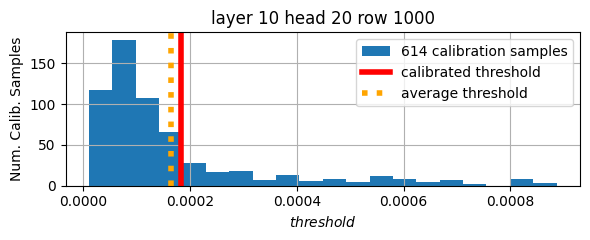

In [8]:
layer = layers[2]
head = heads[3]
row = rows[2]

# print(f"ax[{fig_row},{fig_col}] = layer {layer} head {head} row {row}")
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
calibrated_threshold = df_calib_th[(df_calib_th['layer'] == layer) & (df_calib_th['head'] == head) & (df_calib_th['row'] == row)].calibrated_threshold.item()
df_lhr = df[(df['layer'] == layer) & (df['head'] == head) & (df['row'] == row)]
df_lhr.threshold.hist(bins=20, ax=ax, label=f'{len(df_lhr)} calibration samples')
ax.axvline(x=calibrated_threshold, linewidth=4, color='r', label='calibrated threshold')
ax.axvline(x=df_lhr.threshold.mean(), linewidth=4, color='orange', ls=':', label='average threshold')
ax.legend()
ax.set_xlabel('$threshold$')
ax.set_ylabel('Num. Calib. Samples')
ax.set_title(f'layer {layer} head {head} row {row}')
        
fig.tight_layout()
img_file_name = PLOT_TITLE.replace(" ","-")
img_dir_name = f'../figures/th_histograms/l-{LAYERS if LAYERS=="ALL" else "-".join(map(str, layers))}_heads-{HEADS if HEADS=="ALL" else "-".join(map(str, heads))}_rows-{ROWS if ROWS=="ALL" else "-".join(map(str, rows))}'
os.makedirs(img_dir_name, exist_ok=True)
plt.savefig(f'{img_dir_name}/{img_file_name}_l{layer}_h{head}_r{row}.png')
plt.savefig(f'{img_dir_name}/{img_file_name}_l{layer}_h{head}_r{row}.eps')